## League of Legends Performance Project

Hello, and welcome to my project! For m6y project I am going to be analazing two sets of data from my League of Legends (LoL) data from the past couple of months. The two data sets that I have collected are my ranked games from this season, which spans over the past 6ish months, as well as my past 103 other games. Those 104 games include normal games, ARAM games, and anything else (mostly those two I believe). There is a pretty big chance that whoever is reading this has no knowledge of LoL, so before we get started there are a couple key words that you should know:
* Gamemodes
    * There are multiple gamemodes in LoL, but the ones I've recorded are Ranked, Norms, and ARAM
    * Norms is the baseline of the game, it is also known as Draft sometimes.
    * Ranked is the competative version of Norms, the exact same game and playstyle, but taken more seriously
    * ARAM is usually known as the "for fun" mode, you don't get to choose your champion, and there are no rolls like the other gamemodes
* Rolls
    * Norms and Ranked have different rolls you can play which is an important attribute in my data. There are 5 rolls; Top, Jungle, Middle, ADC, and Support
* Other terms
    * KDA: This is your Kill-Death- assist ratio. Usually, the higher it the better you did. It is calculated with this equation: $\frac{K+A}{D}$ 
    * CS: This is kind of complicated to explain, but it's kind of a way of tracking how well you were managing multiple things.
    * KP: Kill Participation, this is how many of your Kills or Assists contributed to the team. $\frac{K+A}{Team Kills}$
    * Average Rank: This is a way of determining the average skill of the lobby. The rank goes from Bronze->Silver->Gold->Plat->etc. As well as from 4 being the lowest to 1 being the highest of that specific rank
    
With all of that, we can start looking at the data!

### The Data
As I mentioned, I have two data sets that I'll be analyzing. One comprising of all my ranked games this year, and another of my past 103 games. I got this data from the website op.gg, but had to input the data manually into excel since there was no way of getting it as a csv or json. I think that there will be some interesting information that we can find from these datasets as I usually goof off a lot in norms with my friends, but take ranked more seriously and play the champs that I'm best at.  
Let's go through a couple things I want to look at with this data:
* How well I play in ranked vs. norms
* What champs I play the best and worst with (I can also comparte this to how much I've played the champ)
* How well I play by myself vs. with my friends (this can be determined by the avg rank because one of the friends I play with is a lot higher ranked than the rest of us)
* How my performance differs between which roll I play (this might be skewed because I play Jg and Mid the most but we will see)
* And finally I would love to try and predict how well I would play on a given champion in a given roll, and then play a game and see how accurate it was.
    * There is no way that it will be accurate since there are so many variables that go into a single game, but I think it would be really interesting to try
    

In [857]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

ranked_df = pd.read_csv("opgg_ranked.csv", header = 0, index_col="ID")
games_df = pd.read_csv("opgg_lasthundred.csv", header = 0, index_col="ID")

### Cleaning
Since I inputed all of this data manually, there is very little cleaning that we will have to do. However, I made the ranked dataset a month or so before my other data, so there are a couple inconsistancies we have to fix:
1. I recorded one of the champions in the ranked dataset as "Mundo", but "Dr. Mundo" in the other set, so I'll change all of them to Dr. for consistancy.
2. In the outcome attribute, I'll change "Loss" in the ranked set to "Defeat", as it is what I used in the new one because that is the official name.
3. In the ranked dataset, I labeled "Roll" as N/A for ARAM games, but I will replace those with empty values.  
    * (np.NaN doesn't work with string values so ask about this)
4. Lastly, I'm going to seperate the ARAM and Remake games that I played from the dataframe, as they will mess up the data.

Once those are done, the data should be all set for usage!

In [858]:
#turns mundo into Dr.
for value in ranked_df["Champion"]:
    if "mundo" in value.lower():
        ranked_df.replace(value, "Dr. Mundo", inplace=True)
#fixes result name
for value in ranked_df["Result"]:
    if "loss" in value.lower():
        ranked_df.replace(value, "Defeat", inplace=True)
#removes N/A
games_df.replace("N/A", np.NaN, inplace=True)
#makes an aram df in case i want to use it later
aram_df = games_df.loc[games_df["Gamemode"] == "ARAM"]
#although only 2 remakes, it could mess up the data
remove_remakes = games_df.loc[games_df["Result"] == "Remake"]
#removes both from games_df
games_df = games_df.drop(aram_df.index)
games_df = games_df.drop(remove_remakes.index)




While doing this project, I found a great dataset to use that shows the average stats of every champ, and even better it is set to be specifically in my skill range. I got this data from https://www.metasrc.com/5v5/na/12.20/stats?ranks=silver and used a html converter to turn it into a .csv.  

1. One problem arose though, the champion attribute has an issue where the name is coppied on itself, so instead of "Akali", it shows "AkaliAkali". And since this was the attribute I planned on merging my tables on, I'm going to have to fix that. Luckily, I have an idea.
    * Have a for loop that goes through all the champs
    * Get the length of the string that is their name
    * Set the length of the string to half that size.  

        Hopefully this works, and gives me a good dataset to work with.  


2. Another problem is some champions show up twice, this is because some champs are played in multiple rolls. Since I do not really care about their lower played rolls, I will just be taking the highest play percent and drop the extra ones.  
3. One more thing I'm going to do is remove a couple columns that I wont be using.  

For the last part of cleaning, I am going to merge this dataframe with both my ranked df and my norms df.

In [859]:
stats_df = pd.read_csv("champ_stats.csv", header = 0)
 
#Fixes the names
for name in stats_df["Champion"]:
    length = len(name)
    split_index = length // 2
    #sets val equal to first half
    stats_df.replace(name, name[:split_index], inplace=True)
 
#removes the "%" from the values and turns them into ints
for stat in stats_df["Role %"]:
    #sets val equal to first half
    stats_df.replace(stat, float(stat[:5]), inplace=True)
 
#removes all the champs with a roll % less than 50
to_drop = stats_df.loc[stats_df["Role %"] < 50]
stats_df = stats_df.drop(to_drop.index)
 
#drops unnecessary columns
colums_td = ["Score", "Trend", "Pick %", "Ban %"]
stats_df = stats_df.drop(columns=colums_td)
#for some reason these wouldnt drop when I put them in columns_td
stats_df = stats_df.drop(columns="Role")
stats_df = stats_df.drop(columns="Role %")
 
stats_df.rename(columns={'KDA': 'Avg KDA of Champ'}, inplace=True)


# Merging
ranked_df = ranked_df.merge(stats_df, on="Champion")
print(ranked_df)
games_df = games_df.merge(stats_df, on="Champion")




   Gamemode   Result  Length (min)    Roll     Champion    KDA  KP (%)   CS  \
0    Ranked  Victory     33.483333  Jungle       Lillia   5.00      48  191   
1    Ranked   Defeat     16.183333  Jungle       Lillia   0.33      14   74   
2    Ranked  Victory     25.883333  Jungle       Lillia  24.00      57  174   
3    Ranked   Defeat     24.000000  Jungle       Lillia   1.33      42   97   
4    Ranked   Defeat     38.116667  Jungle       Lillia   4.00      63  244   
5    Ranked  Victory     31.900000  Jungle       Lillia   5.25      57  187   
6    Ranked   Defeat     20.816667  Jungle       Lillia   0.80      40  100   
7    Ranked   Defeat     44.300000  Jungle       Lillia   1.78      38  209   
8    Ranked  Victory     22.950000  Jungle  Mordekaiser   4.33      33  125   
9    Ranked   Defeat     16.133333  Jungle  Mordekaiser   1.00      80   74   
10   Ranked  Victory     22.133333  Jungle  Mordekaiser  16.00      53  123   
11   Ranked  Victory     29.450000  Jungle  Mordekai

### Graphs
* I'm going to make 2 pi charts for what percent I play what roll, as well as what Champion. I'm going to make the same for ranked as well.

In [860]:
# Still not working, come back as last thing



# series = champs_graph.apply()

#print(games_df)
# for key in champs_graph:
#     #sets val equal to first half
#     if 
#     champs_graph.replace(key, "Other", inplace=True)
 
# #removes all the champs with a roll % less than 50
# to_drop = stats_df.loc[stats_df["Role %"] < 50]
# stats_df = stats_df.drop(to_drop.index)

# reset figure, make it square
#plt.figure(figsize=(8,8))
# create the bar chart (with pcts)
#plt.pie(grouped_by_champ.size(), labels=grouped_by_champ.size(), autopct="%1.1f%%")
#plt.show()

After seeing this atrocity I have decided not to make a graph based on the champs I've played. I can still do Rolls though since there are only 5.  

I can probably still do the champion graph for ranked though, because I only played 4 champions in ranked I believe. Let's try that out first

Champion
Dr. Mundo      2
Lillia         8
Mordekaiser    8
Vi             1
dtype: int64


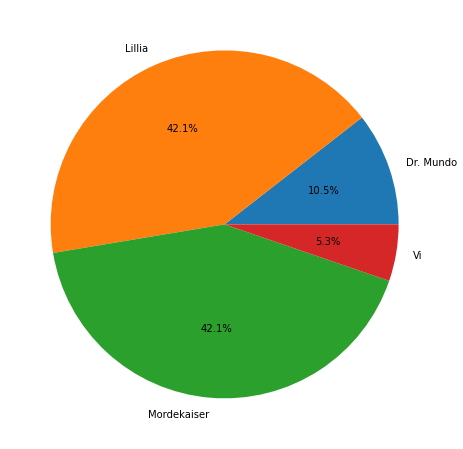

In [861]:
grouped_by_champ = ranked_df.groupby("Champion")

print(grouped_by_champ.size())

plt.figure(figsize=(8,8))

xs = ["Dr. Mundo", "Lillia", "Mordekaiser", "Vi"]

plt.pie(grouped_by_champ.size(), labels=xs, autopct="%1.1f%%")
plt.show()

Lillia and Mord as my top champs. Not suprised since this data set is so small, I know which ones I played most off the top of my head.

I could also make a bar graph with my average KDA with these champs for ranked since there arn't too many to work with. I am guessing that Mord and Lillia will still be the most since I am more experienced with them.

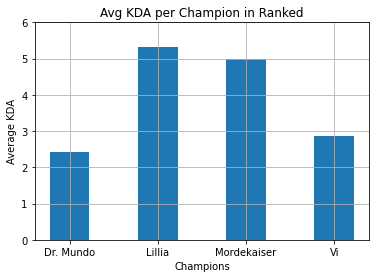

In [862]:
mundo_df = grouped_by_champ.get_group("Dr. Mundo")
lil_df = grouped_by_champ.get_group("Lillia")
mord_df = grouped_by_champ.get_group("Mordekaiser")
vi_df = grouped_by_champ.get_group("Vi")

# reset figure
plt.figure()

ys = [mundo_df["KDA"].mean(), lil_df["KDA"].mean(), mord_df["KDA"].mean(), vi_df["KDA"].mean()]

xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys)+1, 1)

plt.bar(xrng, ys, 0.45, align="center") 
# note: default alignment is center

plt.xlabel("Champions")
plt.ylabel("Average KDA")
plt.title("Avg KDA per Champion in Ranked")

plt.xticks(xrng, xs)
plt.yticks(yrng)
# turn on the background grid
plt.grid(True)
plt.show()

It seems that I was correct in my guess! I am going to move onto rolls now, but I'm not going to do one for ranked since it would be 100% jungle and that would not make for very interesting data.  

I'm also going to make a Bar Graph along with the Pi Chart again since we have a lot more data with my normal game set, and I honestly have no idea what roll will come out on top.


Roll
ADC         7
Jungle     28
Middle     30
Support     5
Top        18
dtype: int64


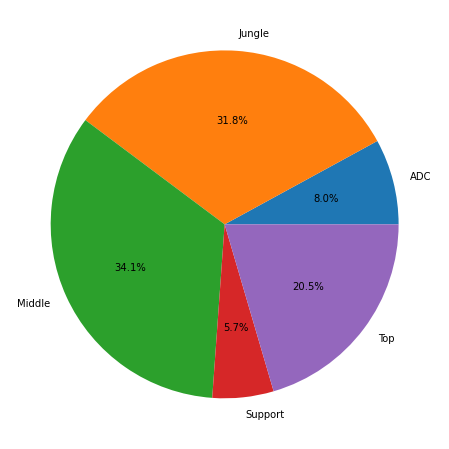

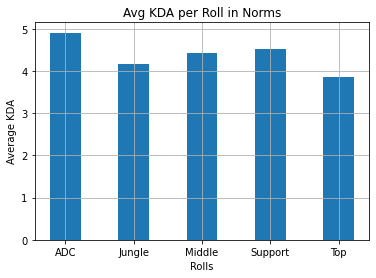

In [863]:

#Pi Chart
grouped_by_roll = games_df.groupby("Roll")

print(grouped_by_roll.size())

plt.figure(figsize=(8,8))

xs = ["ADC", "Jungle", "Middle", "Support", "Top"]

plt.pie(grouped_by_roll.size(), labels=xs, autopct="%1.1f%%")
plt.show()


#Bar Chart
adc_df = grouped_by_roll.get_group("ADC")
jng_df = grouped_by_roll.get_group("Jungle")
mid_df = grouped_by_roll.get_group("Middle")
sup_df = grouped_by_roll.get_group("Support")
top_df = grouped_by_roll.get_group("Top")

# reset figure
plt.figure()

ys = [adc_df["KDA"].mean(), jng_df["KDA"].mean(), mid_df["KDA"].mean(), sup_df["KDA"].mean(), top_df["KDA"].mean()]


xrng = np.arange(len(xs))
yrng = np.arange(0, max(ys)+1, 1)

plt.bar(xrng, ys, 0.45, align="center") 
# note: default alignment is center

plt.xlabel("Rolls")
plt.ylabel("Average KDA")
plt.title("Avg KDA per Roll in Norms")

plt.xticks(xrng, xs)
plt.yticks(yrng)
# turn on the background grid
plt.grid(True)
plt.show()

This data was really surprising to me. All of the rolls have an extremely similar KDA, although it is kind of sad to see that my most played rolls have the lowest average...  

If I were to have gotten this data from two months ago, I think that the data would have been skewed especially towards jungle, but after playing Akali a lot (who is played top and mid), it increased those almost up to my jungle play rate.  

Later on I would like to do this sorted by some ranks as well. Possibly Gold-Plat(playing with friends) vs. Bronze-Silver(playing alone) to see which I play better.  


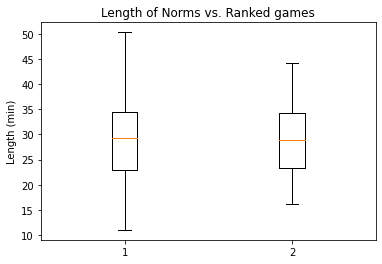

In [864]:
plt.figure()

xs = ["Norms", "Ranked"]
plt.boxplot([games_df["Length (min)"], ranked_df["Length (min)"]])


plt.ylabel("Length (min)")
plt.title("Length of Norms vs. Ranked games")

plt.show()

# Hypothysis Testing
For my hypothysis testing, I am going to test two different hypothysis that I have. First will be if I will beat a certain score with a specific champion, and the next will be based on if I play longer games with my friends or alone. I will explain them in more detain during their sections. These tests will give me a really interesting view on how likely these things are to happen and if I feel the same way.

1. For the first test, I will be running a hypothysis test to see if when I play a game with Akali, if I will get a KDA above 3. I am doing this to see if the champ I played most in these last 100 games or so actually payed off and made me pretty good at the champion or not.

Akali KDA Test
* H0 - $M_{kda} <= 3$
* H1 - $M_{kda} > 3$
* Confidence $= 98$%
* $df = N_{akali} - 1 = 30$
* $t_{critical} = 2.457$

In [865]:
grouped_by_champ = games_df.groupby("Champion")
akali_df = grouped_by_champ.get_group("Akali")

akali_kda = akali_df["KDA"]

t = (akali_kda.mean() - 3)/(akali_kda.std()/math.sqrt(len(akali_kda)))
print("t-computed =", t)

print("\nAverage KDA of Akalis: ", akali_df["Avg KDA of Champ"].mean())

t-computed = 2.066722324107354

Average KDA of Akalis:  2.310000000000001


t-computed is less than t-critical, therefor reject H0. I also printed out another point of data, that the average KDA of Akali players in my rank is 2.3. So not only does my hypothysis test prove that if I play Akali, I will most likely get a KDA above 3, but also that it is significantly higher than the average person in my rank.

2. Next is a bit weirder, but I think it should be interesting. The friends that I play with the most are better at the game than me, and because of that, the average rank of the games go up. Surprisingly, I play about the same weathr I'm playing with them or not, but that is not the point. What I want to test here is if I am playing with my friends, will the game be longer than if I were playing by myself. There is an option in the game to "FF" or forfeit, which ends the game early. However, whenever my friends and I play we rarely do that because we are having fun no matter how winnable the game it. 
* My thought is that if I'm playing with my friends, the length of the game will be longer than if I were playing alone


Jungle CS Test
* H0 - $M_{friends} <= M_{alone}$
* H1 - $M_{frieds} > M_{alone}$
* Confidence $= 98$%
* $df = N_{friends} + N_{alone} - 2 = 86$
* $t_{critical} = 2.390$

In [866]:
from scipy import stats

#this makes a new df to clean that turns the ranks into only 2 different values
avgranks_df = games_df.copy()
for rank in avgranks_df["Average Rank"]:
    if "Gold" in rank:
        avgranks_df.replace(rank, "Higher", inplace=True)
    if "Plat" in rank:
        avgranks_df.replace(rank, "Higher", inplace=True)
    if "Bronze" in rank:
        avgranks_df.replace(rank, "MyElo", inplace=True)
    if "Silver" in rank:
        avgranks_df.replace(rank, "MyElo", inplace=True)

#this will now split the df into 2, one with a higher avg rank, and one with about the same
grouped_by_rank = avgranks_df.groupby("Average Rank")
friends_df = grouped_by_rank.get_group("Higher")
alone_df = grouped_by_rank.get_group("MyElo")




t, p = stats.ttest_ind(friends_df["Length (min)"], alone_df["Length (min)"])
print("t-calculated =", t)


t-calculated = 2.302374480299633


t-computed is less than t-critical, therefor accept H0. Unfortunately my prediction for this one was not correct; however, it was extremely close. If I move the confidence interval down it would have passed. I still think that this was a really interesting test to do, and still got quite close to my hypothysis.



# Machine Learning
First I need to label encode the data, as well as remove any of the columns that wont be necessary such as the Gamemode, since all of them are normal for this data.

In [867]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

to_drop = ["Gamemode", "Tier", "Win %", "Avg KDA of Champ"]
games_ml = games_df.drop(columns=to_drop)


#kindof a roundabout way of encoding both of these, but it works

#Also going to encode the new games df here as well
newgames_df = pd.read_csv("new_games.csv", header = 0, index_col="ID")
newgames_df = newgames_df.drop(columns="Gamemode")

#adding the two df's together to get the same encoding
games_ml = games_ml.append(newgames_df)

#label encoding
le = LabelEncoder()
to_encode = ["Champion", "Roll", "Average Rank"]

le.fit(games_ml["Result"])
games_ml["Result"] = le.fit_transform(games_ml["Result"])

games_ml[to_encode] = games_ml[to_encode].apply(le.fit_transform)

#seperates the dfs
newgames_df = games_ml[88:98]
games_ml = games_ml[0:87]

# split
X = games_ml.drop('Result', axis=1)
y = games_ml['Result']



C:\Users\akeys_abfybfs\AppData\Local\Temp\ipykernel_9484\1208780850.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  games_ml = games_ml.append(newgames_df)


Our data is now all orginized for machine learning! All of our important data is in numbers. We have also split the data into an X and y to work with in ML.

### Decision Tree
The first data model that I will work with is a decision tree, this will give us a basic understanding of what is important in our data.

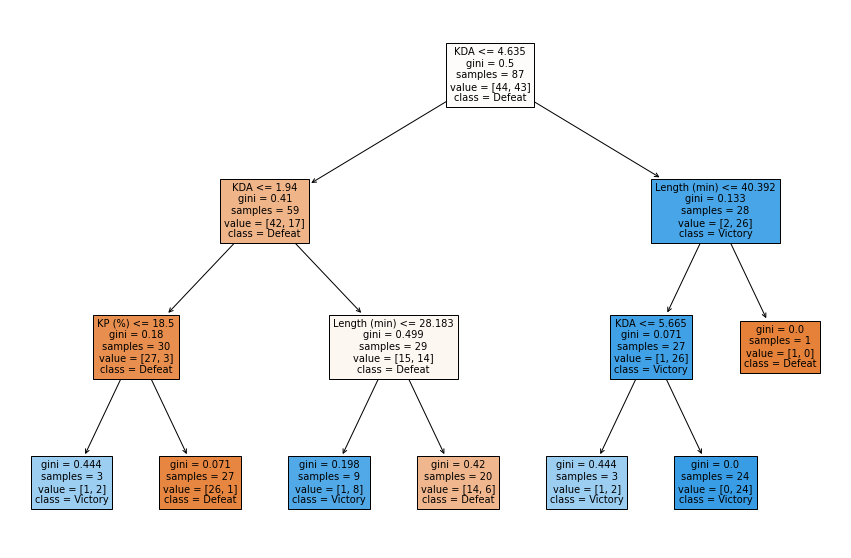

In [868]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

# tree?
fig = plt.figure(figsize=(15,10))
plot_tree(clf, feature_names=X.columns, class_names={1: "Victory", 0: "Defeat"}, filled=True)

plt.show()

Still confused on how decision trees work exactly, try watching a video on it.

Looking at the tree, we can see that my KDA as well as how long the games are play the biggest roll in weather or not I lose. Heres some basic information we can get.
* If my KDA is lower than 1.94, There is a good chance that I will lose.
* If my games last under 40 minutes, but above 30, it is probably a good sign.
* Lastly, KP also plays a slight roll in the big picture.  

The thing I am most surprised about is how there is no branch that has anything to do with the champion that I picked, but I feel like that will be more important in future models such as kNN.  

### Corilation Matrix
One more thing that I want to do before making some predictions is create a corilation matrix, this along with the decision tree we just made will give us a really good understanding of what is important in our data.

In [869]:
corr_df = games_ml.corr()
corr_df.style.background_gradient(cmap='bwr').set_precision(2)

C:\Users\akeys_abfybfs\AppData\Local\Temp\ipykernel_9484\747190788.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_df.style.background_gradient(cmap='bwr').set_precision(2)


,Result,Length (min),Roll,Champion,KDA,KP (%),CS,Average Rank
Result,1.00,-0.28,0.04,-0.04,0.57,-0.06,-0.17,0.02
Length (min),-0.28,1.00,0.13,0.05,-0.08,0.13,0.70,-0.08
Roll,0.04,0.13,1.00,-0.47,-0.05,-0.12,0.04,0.05
Champion,-0.04,0.05,-0.47,1.00,0.01,-0.12,-0.01,-0.13
KDA,0.57,-0.08,-0.05,0.01,1.00,0.18,-0.07,0.12
KP (%),-0.06,0.13,-0.12,-0.12,0.18,1.00,-0.02,-0.21
CS,-0.17,0.70,0.04,-0.01,-0.07,-0.02,1.00,-0.02
Average Rank,0.02,-0.08,0.05,-0.13,0.12,-0.21,-0.02,1.00


Say how KDA very important, make sense cause less deth more kill mean prolly win, surprised time isnt as much, and also show like length direcrly relare to rtime


### Accuracy Testing

In [870]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier


# scaling X
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#did some testing and 11 was the best for kNN
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train, y_train)

# accuracy test
r2score = knn.score(X_test, y_test)
print("kNN score:", r2score)


#Decision Tree score from early decision tree
r2score = clf.score(X_test, y_test)
print("Clf score:", r2score)


kNN score: 0.6818181818181818
Clf score: 0.9090909090909091


idk words words words


### Predictions


In [871]:
results = newgames_df["Result"] 
newgames_df = newgames_df.drop(columns="Result")

knnpredictions = knn.predict(newgames_df)
print("kNN Predictions", knnpredictions)
dtpredictions = clf.predict(newgames_df)
print("Decision Tree Predictions", dtpredictions)
print("\nReal Results")
for i in results:
    print(i, end=" ")



kNN Predictions [0 0 1 1 0 1 1 1 1 0]
Decision Tree Predictions [0 0 0 1 0 1 0 1 1 1]

Real Results
0 1 1 1 0 1 0 1 1 1 

Honestly not horrible, 60% success isnt bad, maybe get more old games as well to have a bigger set to predict from